# _Test Analysis_

In [10]:
import pandas as pd
import configparser

config = configparser.ConfigParser()
config.read('C:/Users/Admin/Code/PROPHET-Load_LSTM/lstm_forecaster.ini')
n_timesteps = config.getint('data_opt', 'n_timesteps')

# Load

In [11]:
proj_dir = r'C:/Users/Admin/Code/PROPHET-Load_LSTM/'
out_dir = r'data/output/impianto_4/u576_nb480_d1/'
#out_dir = r'data/output/impianto_4/peak/hp_search/'

forecast_filename = 'test_forecasts_debug.csv'

df = pd.read_csv(proj_dir + out_dir + forecast_filename,
                 index_col=0,
                 parse_dates=['timestamp_forecast_update','timestamp_forecast'])

df = df.rename(columns={'predicted_activepower_ev_1':'predict',
                        'power':'load'})

df #[df.timestamp_forecast_update=='2019-9-13']

,timestamp_forecast_update,timestamp_forecast,predict,persist,load
0,2019-09-13,2019-09-13 00:00:00,15.639225,17.367902,16.055685
1,2019-09-13,2019-09-13 00:15:00,16.267834,16.910835,16.141277
2,2019-09-13,2019-09-13 00:30:00,16.590502,17.360092,15.887679
3,2019-09-13,2019-09-13 00:45:00,16.768347,16.807852,16.271505
4,2019-09-13,2019-09-13 01:00:00,16.874498,17.059452,15.876782
...,...,...,...,...,...
139,2019-09-13,2019-09-14 10:45:00,17.251640,12.785610,10.566479
140,2019-09-13,2019-09-14 11:00:00,17.251640,12.615742,10.512808
141,2019-09-13,2019-09-14 11:15:00,17.251640,12.541457,10.074268
142,2019-09-13,2019-09-14 11:30:00,17.251640,12.618648,9.529883


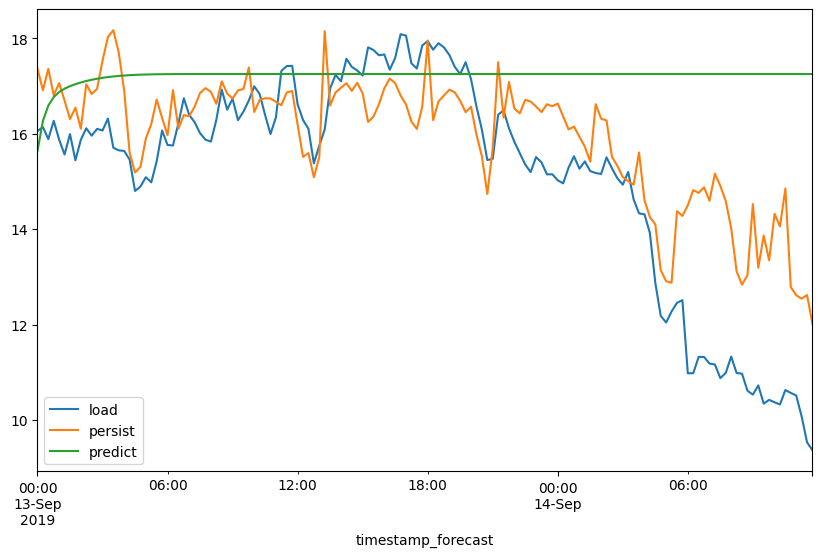

In [12]:
df.plot(x='timestamp_forecast',y=['load','persist','predict'],legend=True,figsize=(10,6));

To match the test code, resample to 4-hourly forecast updates

In [13]:
# idx = pd.date_range('2019-9-13 0:00','2019-12-27 23:00',freq='4h')
# df = df.loc[df.timestamp_forecast_update.isin(idx)].copy()
# df

Checks

In [14]:
assert df.loc[(df.persist-df.load)==0,:].shape[0] == 0 # is persist perfect?
assert df.isna().sum().sum() == 0 # any nans?
for t in df.timestamp_forecast_update.unique(): # completeness?
    assert df.loc[df.timestamp_forecast_update==t,:].shape[0] == 144 #n_timesteps

Errors

In [15]:
mae_pers = (df.persist-df.load).abs().mean()
mae_pred = (df.predict-df.load).abs().mean()
skill = (1 - mae_pred / mae_pers)

print(f'MAE%: pers {100*mae_pers:.2f} pred {100*mae_pred:.2f}')
print(f'Skill%: {100*skill:.3f}')

MAE%: pers 118.51 pred 220.89
Skill%: -86.386


Fraction of positive skills

In [16]:
skills = 1 - (df.load - df.predict).abs() / \
              (df.load - df.persist).abs()
              
len(skills[skills>0]) / len(skills)

0.2847222222222222

Fraction of postive skills (for each `timestamp_update`)

In [17]:
skills = [] 

for t in df.timestamp_forecast_update.unique():
    forecast_now = df.loc[df.timestamp_forecast_update==t]
    test_mae_pers_now = (forecast_now.persist-forecast_now.load).abs().mean()
    test_mae_pred_now = (forecast_now.predict-forecast_now.load).abs().mean()
    test_skill_now = 1 - test_mae_pred_now / test_mae_pers_now
    skills.append( test_skill_now )
    
len([x for x in skills if x > 0])/len(skills)


0.0

Percentage of postive skills (for each `timestamp_forecast_update` at 0:00)

In [18]:
skills = [] 

for t in df.timestamp_forecast_update.unique():
    if t.hour == 0 and t.minute == 0:
        forecast_now = df.loc[df.timestamp_forecast_update==t]
        test_mae_pers_now = (forecast_now.persist-forecast_now.load).abs().mean()
        test_mae_pred_now = (forecast_now.predict-forecast_now.load).abs().mean()
        test_skill_now = 1 - test_mae_pred_now / test_mae_pers_now
        skills.append( test_skill_now )
    
len([x for x in skills if x > 0])/len(skills)


0.0

# Peak load

Goal is just the midnight update day-ahead peak load

In [19]:
proj_dir = r'C:/Users/Admin/Code/PROPHET-Load_LSTM/'
#out_dir = r'data/output/impianto_4/peak/u24_nb96_d1/'
out_dir = r'data/output/zeh/peak/u144_nb672_d2/'

forecast_filename = 'test_forecasts.csv'

df = pd.read_csv(proj_dir + out_dir + forecast_filename,
                 index_col=0,
                 parse_dates=['timestamp_forecast_update','timestamp_forecast'])

df = df.rename(columns={'predicted_activepower_ev_1':'predict',
                        'PotenzaMax':'load',
                        'EtotDailyPeak':'load'
                        })

# max_load = pd.read_csv('data/input/Impianto_4_clean_emd_peaks.csv',
#                        comment='#',
#                        usecols=[1]).values.max()

# df[['predict']]

df #.describe()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Admin/Code/PROPHET-Load_LSTM/data/output/zeh/peak/u144_nb672_d2/test_forecasts.csv'

In [ ]:
(df.load-df.persist).abs().mean(),(df.load-df.predict).abs().mean()

(0.03707110290856506, 0.006494817438527863)

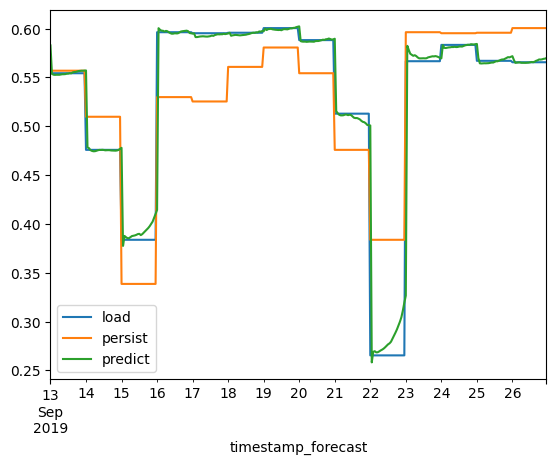

In [ ]:
t = df.timestamp_forecast_update.unique()[2*168]
df[df.timestamp_forecast_update<t].set_index('timestamp_forecast')[['load','persist','predict']].plot();

In [ ]:
df_daily = pd.DataFrame()
for t in df.timestamp_forecast_update.unique():
    df_daily = pd.concat((df_daily,
                        df.loc[df.timestamp_forecast_update==t].iloc[:96,:]\
                            .drop(columns=['timestamp_forecast_update'])))
df = df_daily.set_index('timestamp_forecast').copy()

dfp = df.resample('1d').max()
dfp

,predict,persist,load
timestamp_forecast,,,
2019-09-13,0.582792,0.556918,0.554331
2019-09-14,0.557175,0.509760,0.475878
2019-09-15,0.477935,0.338624,0.383797
2019-09-16,0.600448,0.529883,0.596332
2019-09-17,0.595111,0.525415,0.595295
...,...,...,...
2019-12-23,0.652453,0.665080,0.656616
2019-12-24,0.705299,0.707321,0.710890
2019-12-25,0.711585,0.734613,0.716163


In [ ]:
mae_pers = (dfp.load - dfp.persist).abs().mean()
mae_pred = (dfp.load - dfp.predict).abs().mean()
skill = 1 - mae_pred / mae_pers

print(f'MAE%: pers={100*mae_pers:.2f} pred={100*mae_pred:.2f}')
print(f'Skill%: {100*skill:.2f}')

MAE%: pers=3.71 pred=6.04
Skill%: -62.81


# Peak hour

In [43]:
import pandas as pd

proj_dir = r'C:/Users/Admin/Code/PROPHET-Load_LSTM/'
out_dir = r'data/output/impianto_4/peakhour/hpsearch-test/'
#out_dir = r'data/output/impianto_4/peakhour/u72_nb192_d2/'
#out_dir = r'data/output/zeh/peak/u144_nb672_d2/'

forecast_filename = 'test_forecasts_u72_nb120_d0.0.csv'

df = pd.read_csv(proj_dir + out_dir + forecast_filename,
                 index_col=0,
                 parse_dates=['timestamp_forecast_update','timestamp_forecast'])

df = df.rename(columns={'PotenzaDailyPeakHour':'hour',
                        'predicted_activepower_ev_1':'predict_hour',
                        'persist':'persist_hour'})

df.hour = df.hour.astype(int)
df.persist_hour = df.persist_hour.astype(int)

df #.describe()

,timestamp_forecast_update,timestamp_forecast,predict_hour,persist_hour,hour
0,2019-09-13,2019-09-13,12.453467,3,16
1,2019-09-14,2019-09-14,2.819761,0,0
2,2019-09-15,2019-09-15,10.463637,10,10
3,2019-09-16,2019-09-16,17.937860,17,15
4,2019-09-17,2019-09-17,16.607475,15,11
...,...,...,...,...,...
101,2019-12-23,2019-12-23,17.561860,16,11
102,2019-12-24,2019-12-24,17.283602,17,17
103,2019-12-25,2019-12-25,13.948132,12,17
104,2019-12-26,2019-12-26,11.913560,18,0


In [44]:
df = df.set_index('timestamp_forecast_update')

df = df[['predict_hour','persist_hour','hour']]
df['predict_hour_trn'] = [int(x) for x in df.predict_hour]
df['predict_hour_rnd'] = [int(round(x,0)) for x in df.predict_hour]

df.predict_hour_trn = df.predict_hour_trn.astype(int)
df.predict_hour_rnd = df.predict_hour_rnd.astype(int)

dfp = df.copy()

Truncate

In [45]:
acc_pers = (dfp.hour == dfp.persist_hour).sum() / len(dfp)
acc_pred = (dfp.hour == dfp.predict_hour_trn).sum() / len(dfp)
skill = 1 - acc_pers / acc_pred

print(f'ACC%: pers={100*acc_pers:.2f} pred={100*acc_pred:.2f}')
print(f'Skill%: {100*skill:.2f}')

ACC%: pers=12.26 pred=16.98
Skill%: 27.78


Round

In [46]:
acc_pers = (dfp.hour == dfp.persist_hour).sum() / len(dfp)
acc_pred = (dfp.hour == dfp.predict_hour_rnd).sum() / len(dfp)
skill = 1 - acc_pers / acc_pred

print(f'ACC%: pers={100*acc_pers:.2f} pred={100*acc_pred:.2f}')
print(f'Skill%: {100*skill:.2f}')

ACC%: pers=12.26 pred=11.32
Skill%: -8.33
